In [1]:
from numpy.random import normal
from numpy import cos, sin, pi, linspace, array, concatenate, append, array
from random import random, sample, choices

from pandas import DataFrame, read_csv
import geopandas as gpd

from shapely.geometry import MultiPoint

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import rasterio

from numba import njit
from numba.typed import List

import plotly.express as px

In [99]:
def generateRandomHalo():
    
    r = random()+sample([0,1],1)[0]

    h = random()*20
    k = random()*20

    x = r*cos(linspace(0,2*pi,700))+h
    x = [i+normal()/10 for i in x]
    
    y = r*sin(linspace(0,2*pi,700))+k
    y = [i+normal()/10 for i in y]

    return [x,y]

In [100]:
def generateRandomForest(n,p):
    x = array([])
    y = array([])
    
    for _ in range(n):
        halos = generateRandomHalo()
        x = concatenate((x,halos[0]))
        y = concatenate((y,halos[1]))
        
    p = int(len(x)*p/100)
    
    xs = choices(range(int(min(x)),int(max(x))),k=p)
    ys = choices(range(int(min(y)),int(max(y))),k=p)

    x = concatenate((x,[i+normal() for i in xs]))
    y = concatenate((y,[i+normal() for i in ys]))

    return x,y
    

In [2]:
def dbscanTrees(data, eps, samp):
    
    clustering = DBSCAN(eps =eps, min_samples = samp).fit(data)
    labels = clustering.labels_

    print('Número de troncos: ',len(set(labels)) - (1 if -1 in labels else 0))

    return labels

In [3]:
def inputDBscan(df,x,y):
    return [[i,j] for i,j in zip(df[x],df[y])]

In [4]:
@njit
def mesureTreeHeight(x,y,z,matrix,geoTrans):
    
    h = List()
    
    cx= geoTrans[0]/2 + geoTrans[2]
    cy= geoTrans[4]/2  + geoTrans[-4]
    
    for i,j,k in zip(x,y,z):
        icol = round((i-cx)/geoTrans[0])
        irow = round((j-cy)/geoTrans[4])
        h.append(k-rmatriz[irow,icol])
        
    return h 

## Datos artificiales (utópicos)

In [10]:
x,y = generateRandomForest(10,20)

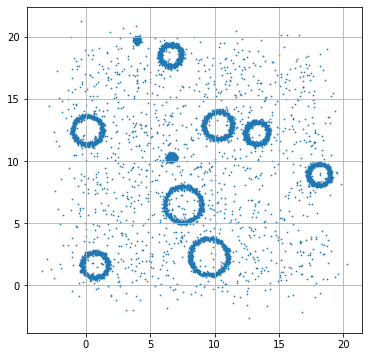

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,s=.5)
plt.grid()
plt.savefig('RandomData.png',dpi=150,bbox_inches='tight')

In [13]:
coords = DataFrame({'x':x,'y':y})

In [14]:
data = [[i,j] for i,j in zip(x,y)]

In [15]:
coords['label'] = dbscanTrees(data,.15, 10)

Número de troncos:  10


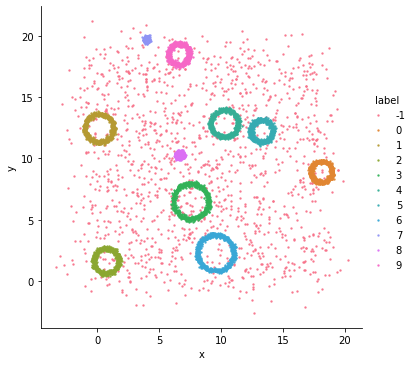

In [16]:
sns.lmplot(x='x',y='y', data=coords, hue='label', fit_reg=False, scatter_kws={"s": 2})
plt.savefig('RandomDataClassified.png',dpi=150,bbox_inches='tight')
plt.show()

In [17]:
sr=coords[coords.label!=-1]

In [18]:
gsr=gpd.GeoDataFrame(sr,geometry=gpd.points_from_xy(sr.x,sr.y))

In [19]:
troncos = []
for i in gsr.label.unique():
    
    log = gsr[gsr.label==i]
    pts=[(i,j) for i,j in zip(log.geometry.x,log.geometry.y)]
    
    troncos.append(MultiPoint(pts))

In [20]:
logs=gpd.GeoDataFrame({'id':gsr.label.unique(),'geometry':troncos})

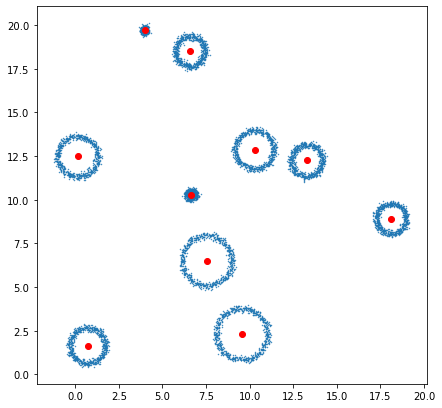

In [21]:
ax=logs.plot(figsize=(7,7),markersize=.2)
logs.centroid.plot(ax=ax,color='red');
plt.savefig('RandomDataClassified_NoNoiseCentroid.png',dpi=150,bbox_inches='tight')

## Caso Real Terrestre (Jardín de la Isla)

In [978]:
df = read_csv('lidar_mano.csv',usecols=['X','Y','ELEVATION'],
              dtype={'X':float,'Y':float,'ELEVATION':float})

In [979]:
sub=df[(df.ELEVATION<5) & (df.ELEVATION>3)].copy()

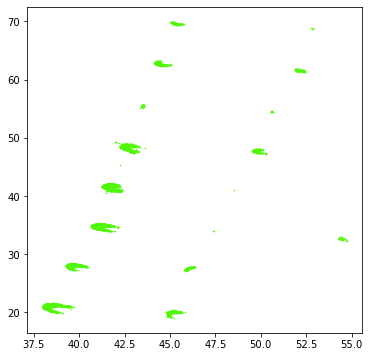

In [980]:
plt.figure(figsize=(6,6), edgecolor='y')
plt.scatter(sub.X,sub.Y,s=.3,c='#50f807');
plt.savefig('Outputs/TerrestrialLidarTree.png',dpi=150,bbox_inches='tight')

In [981]:
data = inputDBscan(sub, 'X', 'Y')

In [982]:
sub['label'] = dbscanTrees(data, 2, 50)

Número de troncos:  12


In [983]:
sub = sub[sub.label!=-1]

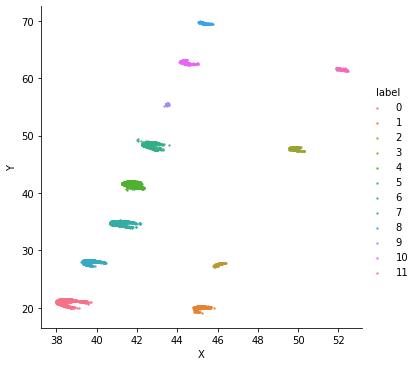

In [984]:
sns.lmplot(x='X',y='Y', data=sub, hue='label', fit_reg=False, scatter_kws={"s": 2})
plt.savefig('Outputs/TerrestrialLidarTree_Classified.png',dpi=150,bbox_inches='tight')
plt.show()

In [985]:
sub.label.value_counts()

4     1570
6     1558
5     1322
7     1171
0      827
10     603
2      266
1      247
8      197
3      148
9      112
11      92
Name: label, dtype: int64

In [989]:
circ=sub[sub.label==4]

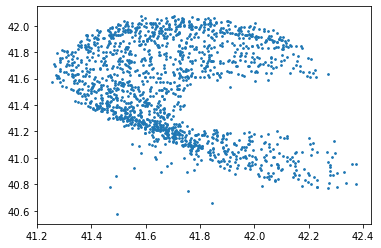

In [994]:
plt.scatter(circ.X,circ.Y,s=3);

## Caso Real Aereo (Yuncos)

In [6]:
raster = rasterio.open("terreno_Yuncos.tif")

In [120]:
raster.crs.wkt

'LOCAL_CS["GCS_ETRS_1989",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3042"]]'

In [30]:
csv=read_csv("Yuncos_arboles_corte.csv",usecols=["X","Y","ELEV"],
            dtype={"x":float,"Y":float,"ELEV":float})

In [33]:
csv

,X,Y,ELEV
0,424995.147,4437011.448,561.642944
1,424995.208,4437011.579,561.834717
2,424995.131,4437011.491,561.692810
3,424995.218,4437011.500,561.811340
4,424995.207,4437011.687,561.904846
...,...,...,...
5780682,425099.166,4437010.673,554.940735
5780683,425099.206,4437010.484,556.957947
5780684,425099.184,4437010.570,556.884521
5780685,425099.184,4437010.695,556.839661


In [35]:
rmatriz=raster.read(1)

rmatriz.shape,rmatriz.shape[0]*rmatriz.shape[1]

((12491, 13716), 171326556)

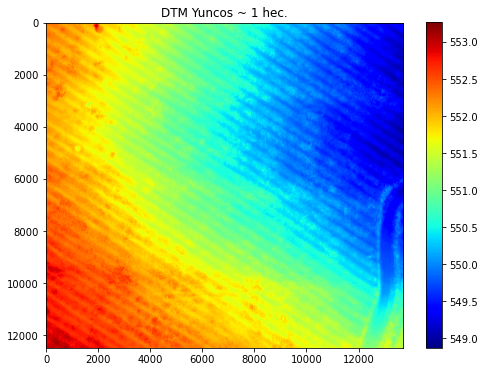

In [37]:
plt.figure(figsize=(8,8))
plt.title('DTM Yuncos ~ 1 hec.')
plt.imshow(rmatriz,cmap="jet")
plt.colorbar(shrink=.75);

In [22]:
geoTrans = tuple(raster.transform)

In [23]:
x = List(csv.X)
y = List(csv.Y)
z = List(csv.ELEV)

In [24]:
alturas = mesureTreeHeight(x,y,z,rmatriz,geoTrans)

In [25]:
%timeit mesureTreeHeight(x,y,z,rmatriz,geoTrans)

356 ms ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
csv['alturas']=list(alturas)

In [217]:
corte1=csv[(csv.alturas<1.35) & (csv.alturas>1.25)].copy()
corte2=csv[(csv.alturas<1.55) & (csv.alturas>1.45)].copy()
corte3=csv[(csv.alturas<1.60) & (csv.alturas>1.40)].copy()
corte4=csv[(csv.alturas<2.05) & (csv.alturas>1.95)].copy()
corte5=csv[(csv.alturas<2.55) & (csv.alturas>2.45)].copy()
corte6=csv[(csv.alturas<3.05) & (csv.alturas>2.95)].copy()

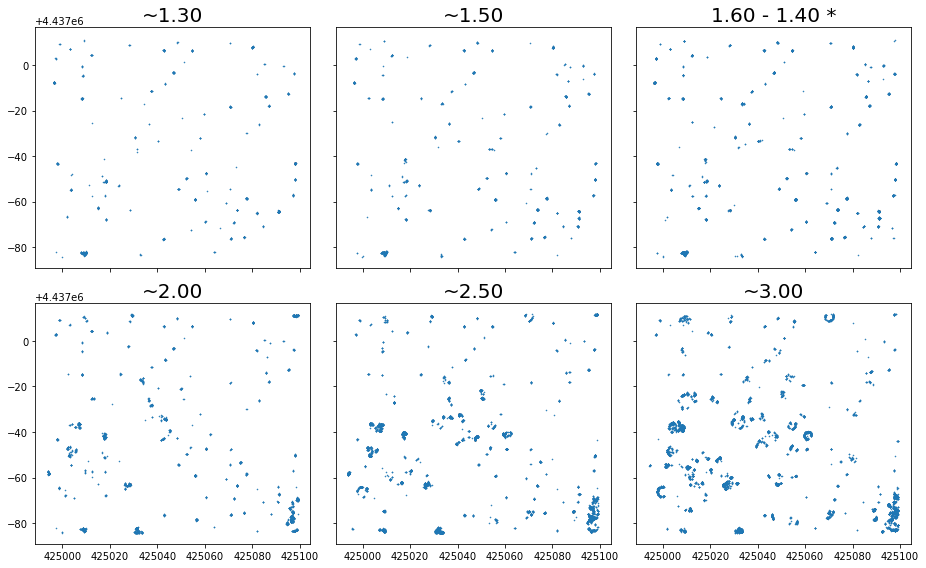

In [219]:
figure, axes = plt.subplots(nrows=2, ncols=3,sharex=True,sharey=True,figsize=(13,8))

axes[0, 0].scatter(corte1.X,corte1.Y,s=.3)
axes[0, 0].set_title('~1.30',fontsize=20)

axes[0, 1].scatter(corte2.X,corte2.Y,s=.3)
axes[0, 1].set_title('~1.50',fontsize=20)

axes[0, 2].scatter(corte3.X,corte3.Y,s=.3)
axes[0, 2].set_title('1.60 - 1.40 *',fontsize=20)

axes[1, 0].scatter(corte4.X,corte4.Y,s=.3)
axes[1, 0].set_title('~2.00',fontsize=20)

axes[1, 1].scatter(corte5.X,corte5.Y,s=.3)
axes[1, 1].set_title('~2.50',fontsize=20)

axes[1, 2].scatter(corte6.X,corte6.Y,s=.3)
axes[1, 2].set_title('~3.00',fontsize=20)

figure.tight_layout()

In [242]:
corte1['label'] = dbscanTrees(corte1, 1.5, 3) 

len(corte1[corte1.label==-1]),len(corte1)

Número de troncos:  58


(35, 958)

In [243]:
corte2['label'] = dbscanTrees(corte2, 1.5, 3)

len(corte2[corte2.label==-1]),len(corte2)

Número de troncos:  67


(33, 1055)

In [250]:
corte3['label'] = dbscanTrees(corte3, 1.5, 3)

len(corte3[corte3.label==-1]),len(corte3)

Número de troncos:  83


(29, 2141)

In [254]:
corte4['label'] = dbscanTrees(corte4, 1.5, 4)

len(corte4[corte4.label==-1]),len(corte4)

Número de troncos:  81


(61, 2706)

In [257]:
corte5['label'] = dbscanTrees(corte5, 1.5, 7)

len(corte5[corte5.label==-1]),len(corte5)

Número de troncos:  82


(138, 5701)

In [260]:
corte6['label'] = dbscanTrees(corte6, 1.5, 9)

len(corte6[corte6.label==-1]),len(corte6)

Número de troncos:  81


(224, 8108)

In [251]:
corte1.to_csv('outputs/output_130.csv',index=False)
corte2.to_csv('outputs/output_150.csv',index=False)
corte3.to_csv('outputs/output_167d.csv',index=False)
corte4.to_csv('outputs/output_200.csv',index=False)
corte5.to_csv('outputs/output_250.csv',index=False)
corte6.to_csv('outputs/output_300.csv',index=False)